## Thermal Conduction
This examples shows how OpenPNM can be used to simulate thermal conduction on a generic grid of nodes. The result obtained from OpenPNM is compared to the analytical result. 

As usual, start by importing OpenPNM, and the SciPy library.

In [1]:
%matplotlib inline
import scipy as sp
import openpnm as op

## Generating the Network object

Next, 2D a **Network** is generated with dimensions of 10x50 elements. The lattice spacing is given by *Lc*. Boundaries are added all around the edges of **Network** object using the ``add_boundariy_pores`` method. 

In [2]:
divs = [10, 50]
Lc = 0.1  # cm
pn = op.network.Cubic(shape=divs, spacing=Lc)
pn.add_boundary_pores(['left', 'right', 'front', 'back'])

## Creating a Phase object
All simulations require a phase object which possess the thermosphysical properties of the system.  In this case, we'll create a generic phase object, call it copper, though it has no properties; we'll add these by hand later.

In [13]:
# Create Phase object and associate with a Physics object
Cu = op.phases.GenericPhase(network=pn)

## Assigning Thermal Conductance to Copper
In a proper OpenPNM model we would create a Geometry object to manage all the geometrical properties, and a Physics object to calculate the thermal conductance based on the geometric information and the thermophysical properties of copper.  In the present case, however, we'll just calculate the conductance manually and assign it to ```Cu```.

In [14]:
# Add a unit conductance to all connections
Cu['throat.thermal_conductance'] = 1
# Overwrite boundary conductances since those connections are half as long
Ps = pn.pores('*boundary')
Ts = pn.find_neighbor_throats(pores=Ps)
Cu['throat.thermal_conductance'][Ts] = 2

## Generating the algorithm objects and running the simulation
The last step in the OpenPNM simulation involves the generation of a **Algorithm** object and running the simulation. 

In [7]:
# Setup Algorithm object
alg = op.algorithms.FourierConduction(network=pn)
alg.setup(phase=Cu)
inlets = pn.pores('back_boundary')
outlets = pn.pores(['front_boundary', 'left_boundary', 'right_boundary'])
T_in = 30*sp.sin(sp.pi*pn['pore.coords'][inlets, 1]/5)+50
alg.set_value_BC(values=T_in, pores=inlets)
alg.set_value_BC(values=50, pores=outlets)
alg.run()

This is the last step usually required in a OpenPNM simulation. The algorithm was run, and now the simulation data obtained can be analyzed. For illustrative purposes, the results obtained using OpenPNM shall be compared to an analytical solution of the problem in the following.

First let's rehape the 'pore.temperature' array into the shape of the network while also extracting only the internal pores to avoid showing the boundaries.

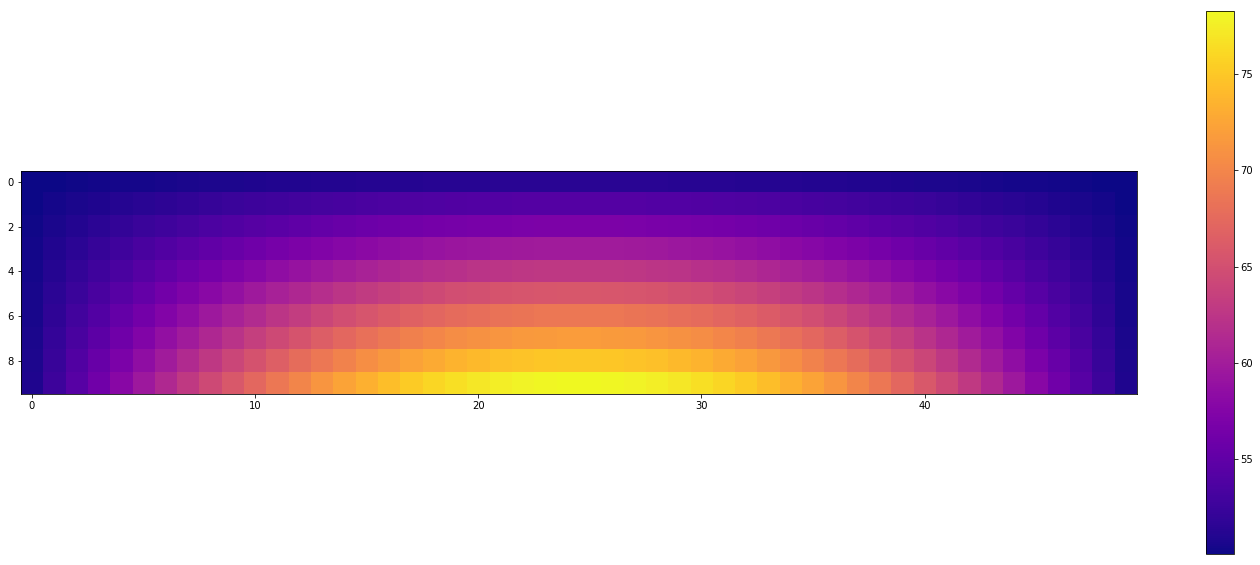

In [8]:
import matplotlib.pyplot as plt
sim = alg['pore.temperature'][pn.pores('internal')]
temp_map = sp.reshape(a=sim, newshape=divs)
plt.subplots(1, 1, figsize=[25, 10])
plt.imshow(temp_map, cmap=plt.cm.plasma)
plt.colorbar()

The analytical solution is computed as well, and the result is the same shape as the network (including the boundary pores). 

In [9]:
# Calculate analytical solution over the same domain spacing
X = pn['pore.coords'][:, 0]
Y = pn['pore.coords'][:, 1]
soln = 30*sp.sinh(sp.pi*X/5)/sp.sinh(sp.pi/5)*sp.sin(sp.pi*Y/5) + 50
soln = soln[pn.pores('internal')]
soln = sp.reshape(soln, (divs[0], divs[1]))

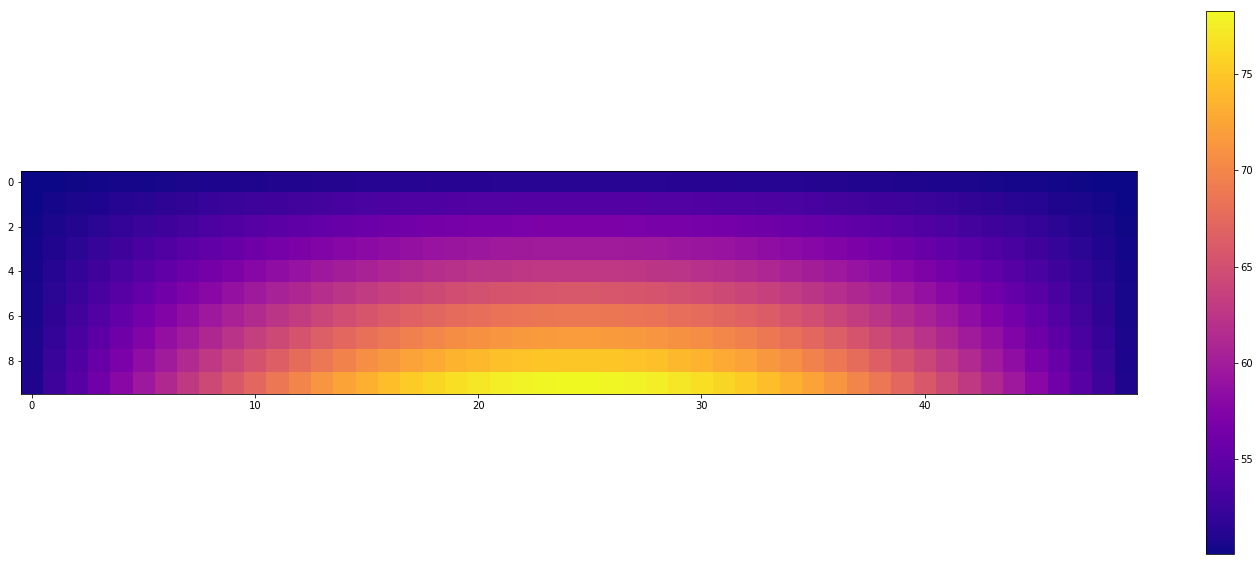

In [15]:
plt.subplots(1, 1, figsize=(25, 10))
plt.imshow(soln, cmap=plt.cm.plasma)
plt.colorbar()

Both the analytical solution and OpenPNM simulation can be subtracted from each other to yield the difference in both values.

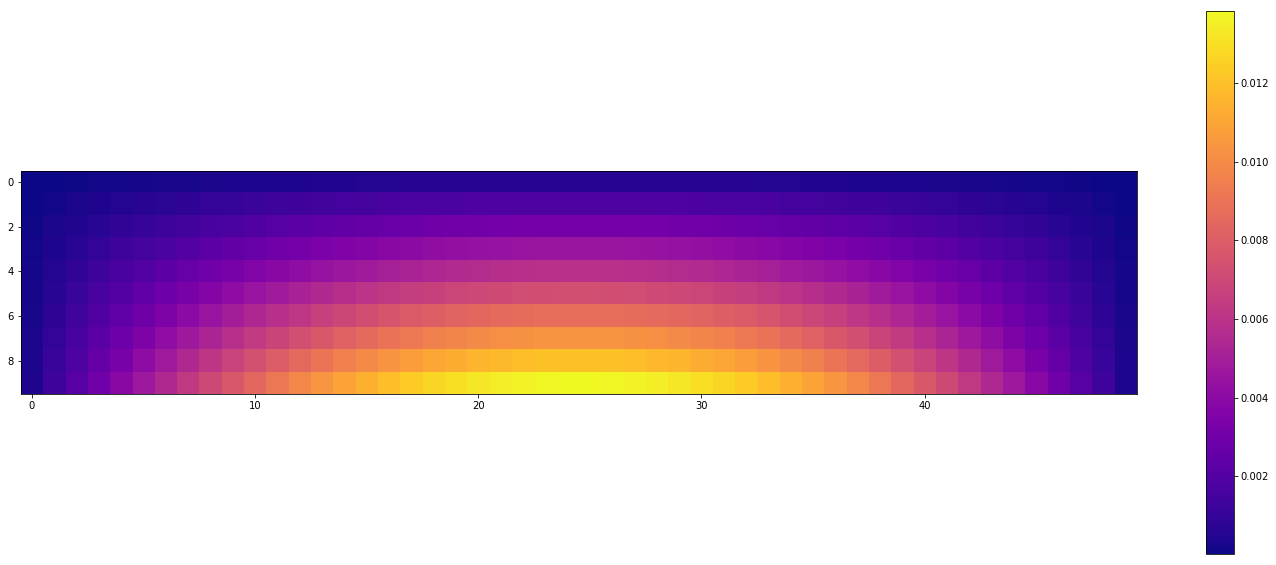

In [11]:
diff = soln - temp_map
plt.subplots(1, 1, figsize=(25, 10))
plt.imshow(diff, cmap=plt.cm.plasma)
plt.colorbar()

In [12]:
print(diff.min(), diff.max())

1.9912515625719607e-05 0.013840915744964377


The maximum error is 0.01 degrees on a 50 degree profile, which is quite good and thus demonstrates that the OpenPNM finite difference approach is versatile despite being simple.